In [1]:
import sys
sys.path.append("/root/anaconda3/Lib/site-packages/")
sys.path.append("root/Users/robert/anaconda3/Lib/site-packages")
import MLC_GP.MLC_GP as gp
import gymnasium as gym
import random
import numpy as np
import pde
import copy
import math
import gc
import time
from time import process_time

In [2]:
#to make gymanasium work with py-pde, need to pass in action step:
#1.  control function to calculate control with all values constant except x,y
#2.  grid
#controller servers to pass these values to gymnasium.
#control will be nxm vector, where n is num_controls and m is number of cells per boundary
#if non-square boundary, m will be larger side and in gymnasium will need to hard code truncation of extra cells

class controller:
    def __init__(self, grid, state, num_sens):
        self.grid=grid
        self.num_sens=num_sens
        self.state=state
        self.control=[]

#need function to reduce full space to just sensors 
def sensor_meas(sensors,domain):
    #assume senors form a square grid, so take square root of number of sensors
    #assume sensors read from middle of domain
    n_sense=int(np.sqrt(sensors))
    meas=np.empty((n_sense,n_sense))
    dimx=domain.shape[0]
    dimy=domain.shape[1]
    startx=round((dimx-n_sense)/2)
    starty=round((dimy-n_sense)/2)
    for i in range(n_sense):
        for j in range(n_sense):
            meas[i,j]=float(domain[i+startx,j+starty])
    return meas.flatten()

In [4]:
env = gym.make("Diffusion-v0")
observation, grid, state = env.reset(seed=412)

#####notes on using gymnasium with py-pde######
#observation needs to be full grid area, but number of sensors will probably be less

#array with target values for sensors

Ni=50 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.5 #for reseed, precent reseeded each round

Num_sens=4*4 #size of observation/sensor space in number of grid points
grid_dim=1 #x,y for including cotnrol location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then 

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=20 #set max number of iterations

#define controls: number of controls, control locations.  Assume control is on boundary
#here, with two control locations and 4 controls, that means that two boundaries have controls.
#In gymanisum this will be hard coded as bottom and right side, or (x,ymin) and (xmax, y)
num_control = 4
control_size = 3 #number of grid points comprising controller
control_points = np.array([8,20]) #grid x/y locations of controllers
dx=1.
dy=1.
xmax=grid.shape[0]*dx
ymax=grid.shape[1]*dy 

implement=controller(grid, state, Num_sens)

#hard code control locations
control_loc=np.array([xmax, dy*control_points[0]]) #right side, 1st control point
control_loc=np.vstack([control_loc,[xmax, dy*control_points[1]]]) #right side, 2nd control point
control_loc=np.vstack([control_loc,[ymax, dx*control_points[0]]]) #top, 1st control point
control_loc=np.vstack([control_loc,[ymax, dx*control_points[1]]]) #top 2nd control point
#controller will be defined by the control vectors passed to py-pde via gymnasium.  Wherever controllers are set (probably here)
#controller location variable is only half of controller location.  the other is which boundaries.  
#can do different location along each boundary or same.  Here, for simplicity, do same along each boundary that has a control.  
#Controls are just boundary conditions on the boundary controls
#however, gymnaisum will have hard-coded which boundaries have controls--this will get "value" as an array

#Generally, implementing control requires planning and some hard coding.  User must know before coding controller how many gridpoints
#are on each boundary with a controller, decide what boundary(ies) to put controller on
#how many control points on the boundary(ies), how many girdpoints each control point uses, if control points are at same location
#on each boundary, and, below, the x/y coordinates for each control point to calculate the control input arries for each boundary.
#the control is implemented by an array with number of values equal to the grid points on the associated boundary.  
#Recommended for easier implementation to make control type same type as boundary layer (i.e. dirchliet vs neumann)
#array will have boundary condition (say, 0 dirchlet) everywhere except the control grid points, which will have value
#determined by algorithm at control point and constant over grid points matching control size.  
#also need to know real extents of boundary--i.e. is each cell 1 unit or 1/32 unit, etc. via dx, dy which is hard coded based on grid design
#i.e. if a right boundary is 32 grid points tall and control location is halfway up the boundary (location 16) with size of 3
#then control will be calculated based on xmax, ymax/2, sensor readings and then applied at cells 15, 16, 17

#need to get initial measurements from observation, fortunately already is a numpy array (!)
#now this is less than Ns (and so then number of variables), remaineders are x,y location for all controllers (num_control)
s=sensor_meas(Num_sens,state.data)
#
K=np.empty(num_control) #dummy initialization of K

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=gp.sapling(3,8,Ns)
    trial=gp.growTrig(0,2,seed)
    forest.append(seed)

minJ=50000 #set initial "best" cost
m=0 #iteration counter

while (minJ>400 and m<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    n=random.randint(0,10000)
    subtotal=0
    for t in forest:
        #reset the environment for each tree using same enivornment for each tree with each time step
        observation, grid, state = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        t.total=0
        s=sensor_meas(Num_sens,state.data)
        #need to take a pass of '500' time steps through environment each tree, each iteration
        #for inverted pendulum need to try on several different seeds becuase getting lucky shots that work for one starting point
        for i in range(100):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            #will need to also replace x and y values for controller locations, which result in a vector of results
            #one element per controller
            #probably have each controller operate across several cells
            #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value

            #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
            for j in range(Num_sens):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]
                
            #then make num_control different vectors, each with different x value
            for j in range(control_loc.shape[0]):
                holder=copy.copy(control_name)
                for k in range(Num_sens, Ns):
                    obs_name='s'+str(k)
                    control_name=[control_loc[j,k-Num_sens].item() if c==obs_name else c for c in control_name]
                k,dummy=gp.evaluate(control_name)
                if k>10:  k=10.0
                elif k<-10:  k=-10.0
                K[j]=k

            #now set up entire array to pass for the boundary
            #hard coded that non-control points will be 0, control points will be as appropriate for that control value
            #need to keep order of boundaries straight for K, for passing to gymnasium, and in gymnasium
            left_bound=np.zeros(grid.shape[1])
            right_bound=np.zeros(grid.shape[1])
            bottom_bound=np.zeros(grid.shape[0])
            top_bound=np.zeros(grid.shape[0])
            for i in range(len(control_points)):
                start=math.floor(control_size/2)
                right_bound[control_points[i]-start:control_points[i]-start+control_size]=K[i].item()
                top_bound[control_points[i]-start:control_points[i]-start+control_size]=K[i+2].item()
            all_bound=np.vstack([left_bound, right_bound])
            all_bound=np.vstack([all_bound, bottom_bound])
            all_bound=np.vstack([all_bound, top_bound])

            implement.control=all_bound
            
            obs, reward, terminated, truncated, info = env.step(implement)
            implement.state.data=obs
            subtotal+=reward
        t.total=subtotal
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(i, minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
        env.close()
    forest=gp.evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
    #     if type(t.name)==bool:  print("selection bool")
    #Np individuals will be ranked and the best will advance to replication, mutation, crossover
    # forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    m+=1
    print(m, minJ, bestTree)

print("best:  ",minJ, bestTree, m)


ImportError: cannot import name 'Diffusion' from 'gymnasium.envs.classic_control.Diffusion' (C:\Users\robert\anaconda3\Lib\site-packages\gymnasium\envs\classic_control\Diffusion.py)

In [15]:
env = gym.make("Diffusion-v0")
observation, grid, state = env.reset(seed=412)

#####notes on using gymnasium with py-pde######
#observation needs to be full grid area, but number of sensors will probably be less

#use one boundary as control surface.  Will need a different gymnasium
#Diffusion v0-2 control points on top, 2 on right.  
#Diffusion v1-entire bottom is control region, use only x (not y) as control variable

Ni=50 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.5 #for reseed, precent reseeded each round

Num_sens=4*4 #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including cotnrol location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then 

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=20 #set max number of iterations

#define controls: number of controls, control locations.  Assume control is on boundary
#here, with two control locations and 4 controls, that means that two boundaries have controls.
#In gymanisum this will be hard coded as bottom and right side, or (x,ymin) and (xmax, y)
#hard code control locations as the bottom boundary:  (x,0)
control_points = np.array(range(grid.shape[0]) #grid x locations of controllers
dx=1.
control_points=dx*control_points
xmax=grid.shape[0]*dx

implement=controller(grid, state, Num_sens)



#Generally, implementing control requires planning and some hard coding.  User must know before coding controller how many gridpoints
#are on each boundary with a controller, decide what boundary(ies) to put controller on
#how many control points on the boundary(ies), how many girdpoints each control point uses, if control points are at same location
#on each boundary, and, below, the x/y coordinates for each control point to calculate the control input arries for each boundary.
#the control is implemented by an array with number of values equal to the grid points on the associated boundary.  
#Recommended for easier implementation to make control type same type as boundary layer (i.e. dirchliet vs neumann)
#array will have boundary condition (say, 0 dirchlet) everywhere except the control grid points, which will have value
#determined by algorithm at control point and constant over grid points matching control size.  
#also need to know real extents of boundary--i.e. is each cell 1 unit or 1/32 unit, etc. via dx, dy which is hard coded based on grid design
#i.e. if a right boundary is 32 grid points tall and control location is halfway up the boundary (location 16) with size of 3
#then control will be calculated based on xmax, ymax/2, sensor readings and then applied at cells 15, 16, 17

#need to get initial measurements from observation, fortunately already is a numpy array (!)
#now this is less than Ns (and so then number of variables), remaineders are x location for controller on bottom boundary
s=sensor_meas(Num_sens,state.data)
#

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=gp.sapling(3,8,Ns)
    trial=gp.growTrig(0,2,seed)
    forest.append(seed)

minJ=50000 #set initial "best" cost
m=0 #iteration counter

while (minJ>400 and m<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    n=random.randint(0,10000)
    subtotal=0
    for t in forest:
        #reset the environment for each tree using same enivornment for each tree with each time step
        observation, grid, state = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        t.total=0
        
        #need to take a pass of '500' time steps through environment each tree, each iteration
        #for inverted pendulum need to try on several different seeds becuase getting lucky shots that work for one starting point
        for i in range(100):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            #will need to also replace x and y values for controller locations, which result in a vector of results
            #one element per controller
            #probably have each controller operate across several cells
            #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value
            s=sensor_meas(Num_sens,state.data)
            #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
            for j in range(Num_sens):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]
            #with control as an entire boundary, only pass that boundary to gymansium step
            #remaining boundaries hard coded in gymnasium
           #then make num_control different vectors, each with different x value
            #assign boundary values based on left, right, bottom, top
            for j in range(control_loc.shape[0]):
                holder=copy.copy(control_name)
                for l in range(Num_sens, Ns):
                    obs_name='s'+str(l)
                    holder=[holder[j,l-Num_sens].item() if c==obs_name else c for c in holder]
                k,dummy=gp.evaluate(control_name)
                if k>10:  k=10.0
                elif k<-10:  k=-10.0
                K[j]=k

            implement.control=all_control
            
            obs, reward, terminated, truncated, info = env.step(implement)
            implement.state.data=obs
            subtotal+=reward
        t.total=subtotal
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(i, minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
        env.close()
    forest=gp.evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
    #     if type(t.name)==bool:  print("selection bool")
    #Np individuals will be ranked and the best will advance to replication, mutation, crossover
    # forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    m+=1
    print(m, minJ, bestTree)

print("best:  ",minJ, bestTree, m)


0

In [13]:
#############################################################
###Using Entire Boundary as control##########################
#############################################################
env = gym.make("Diffusion-v0")
observation, grid, state = env.reset(seed=412)

#####notes on using gymnasium with py-pde######
#observation needs to be full grid area, but number of sensors will probably be less

#array with target values for sensors

Ni=50 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.5 #for reseed, precent reseeded each round

Num_sens=3*3 #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then 

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=50 #set max number of iterations

#define entire boundary as controller.  Use grid's axes_coords attribute to pull coordinates, along with 
#min or max x,y values from axes_bounds to calculate an array of control inputs for each boundary.
#will need to use .item() for each of those

#now set up entire array for boundary coordinates.  first row is x coords, second is y coords
left_bound=grid.axes_coords[1]
left_bound=np.vstack((left_bound, np.full(len(left_bound), grid.axes_bounds[0][0].item())))
right_bound=grid.axes_coords[1]
right_bound=np.vstack((right_bound, np.full(len(right_bound), grid.axes_bounds[0][1].item())))
bottom_bound=grid.axes_coords[0]
bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
top_bound=grid.axes_coords[0]
top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

#initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
right_control=np.zeros(grid.shape[1])
bottom_control=np.zeros(grid.shape[0])
top_control=np.zeros(grid.shape[0])

#controller will be defined by the control vectors passed to py-pde via gymnasium.  Wherever controllers are set (probably here)
#controller location variable is only half of controller location.  the other is which boundaries.  
#can do different location along each boundary or same.  Here, for simplicity, do same along each boundary that has a control.  
#Controls are just boundary conditions on the boundary controls
#however, gymnaisum will have hard-coded which boundaries have controls--this will get "value" as an array

#Generally, implementing control requires planning and some hard coding.  User must know before coding controller how many gridpoints
#are on each boundary with a controller, decide what boundary(ies) to put controller on
#how many control points on the boundary(ies), how many girdpoints each control point uses, if control points are at same location
#on each boundary, and, below, the x/y coordinates for each control point to calculate the control input arries for each boundary.
#the control is implemented by an array with number of values equal to the grid points on the associated boundary.  
#Recommended for easier implementation to make control type same type as boundary layer (i.e. dirchliet vs neumann)
#array will have boundary condition (say, 0 dirchlet) everywhere except the control grid points, which will have value
#determined by algorithm at control point and constant over grid points matching control size.  
#also need to know real extents of boundary--i.e. is each cell 1 unit or 1/32 unit, etc. via dx, dy which is hard coded based on grid design
#i.e. if a right boundary is 32 grid points tall and control location is halfway up the boundary (location 16) with size of 3
#then control will be calculated based on xmax, ymax/2, sensor readings and then applied at cells 15, 16, 17

#need to get initial measurements from observation, fortunately already is a numpy array (!)
#now this is less than Ns (and so then number of variables), remaineders are x,y location for all controllers (num_control)
s=sensor_meas(Num_sens,state.data)

implement=controller(grid, state, Num_sens)

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=gp.sapling(5,10,Ns)
    trial=gp.growTrig(0,2,seed)
    forest.append(seed)

minJ=50000 #set initial "best" cost
m=0 #iteration counter

while (minJ>100 and m<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    n=random.randint(0,10000)
    subtotal=0
    for t in forest:
        #reset the environment for each tree using same enivornment for each tree with each time step
        observation, grid, state = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        t.total=0
        s=sensor_meas(Num_sens,state.data)
        #need to take a pass of '500' time steps through environment each tree, each iteration
        #for inverted pendulum need to try on several different seeds becuase getting lucky shots that work for one starting point
        for i in range(50):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            #will need to also replace x and y values for controller locations, which result in a vector of results
            #one element per controller
            #probably have each controller operate across several cells
            #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value
            s=sensor_meas(Num_sens,implement.state.data)
            #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
            for j in range(Num_sens):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]
            start=time.time()     
            #assign values to boundary controls.  
            #this implementation ASSUMES square grid.  
            #if rectangular need to break into iterating over left/right and top/bottom
            for j in range(grid.shape[0]):
                #left bound
                holder_left=copy.copy(control_name)
                # holder_right=copy.copy(control_name)
                # holder_top=copy.copy(control_name)
                # holder_bottom=copy.copy(control_name)
                for l in range(Num_sens, Ns):
                    obs_name='s'+str(l)
                    holder_left=[left_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_left]
                    # holder_right=[right_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_right]
                    # holder_bottom=[bottom_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_bottom]
                    # holder_top=[top_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_top]
                k,dummy=gp.evaluate(holder_left)
                if k>5:  k=5.0
                elif k<-5:  k=-5.0
                left_control[j]=k
                # k,dummy=gp.evaluate(holder_right)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # right_control[j]=k
                # k,dummy=gp.evaluate(holder_bottom)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # bottom_control[j]=k
                # k,dummy=gp.evaluate(holder_top)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # top_control[j]=k

            #now set up entire array to pass for the boundary
            #hard coded that non-control points will be 0, control points will be as appropriate for that control value
            #need to keep order of boundaries straight for K, for passing to gymnasium, and in gymnasium
            #left, right, bottom, top
            #all_control=np.vstack([left_control, right_control])
            #all_control=np.vstack([all_control, bottom_control])
            #all_control=np.vstack([all_control, top_control])

            implement.control=left_control
            obs, reward, terminated, truncated, info = env.step(implement)
            print(time.time()-start)
            # if i>10 and time.time()-start>6.:
            #     subtotal+=10000
            #     print("lag")
            #     break;
            if truncated:  
                subtotal+=reward
                print("diverged")
                break;
            implement.state.data=obs
            subtotal+=reward
        t.total=subtotal
        print(m)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(m, minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
        gc.collect()
        env.close()
    forest=gp.evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
    

C:\Users\bob\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:192: UserWarning: WARN: The result returned by `env.reset()` should be `(obs, info)` by default, , where `obs` is a observation and `info` is a dictionary containing additional information.
  logger.warn(
C:\Users\bob\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


8.537052392959595
8.257225513458252
8.464383363723755


KeyboardInterrupt: 

In [3]:
# Open the file in binary mode 
forest=[]
import pickle
with open('file.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    forest = pickle.load(file) 


In [4]:
#############################################################
###Using Entire Boundary as control.##########################
#############################################################
####Currently not using gymnasium, need to remove some comments and update gym to use with gymansium###

#need to update use of gym to account for changes made to accomdate SAC script

#env = gym.make("Diffusion-v0")
from pde import DiffusionPDE, ScalarField, UnitGrid
#observation, grid, state0 = env.reset(seed=412) uncomment for use with gym
grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
state = ScalarField.random_uniform(grid, 0.0, 0.2)  #remove if use gym
#####notes on using gymnasium with py-pde######
#observation needs to be full grid area, but number of sensors will probably be less

#array with target values for sensors

Ni=100 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.4 #for reseed, precent reseeded each round

Num_sens=3*3 #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then x,y are last 2 elements

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=50 #set max number of iterations
dt=0.2 #timestep for iteration

#define entire boundary as controller.  Use grid's axes_coords attribute to pull coordinates, along with 
#min or max x,y values from axes_bounds to calculate an array of control inputs for each boundary.
#will need to use .item() for each of those

#now set up entire array for boundary coordinates.  first row is x coords, second is y coords
##############FIX#####################
#bottom and top should have constant value for y and variable for x; left and right should have const x and variable y
#not super important as long as consistent for all controls which sN, sN-1 variables map to what
#axes_bounds[0][1] is max x
#bounds are x cord 1st row, y coord 2nd row
#uncomment if using boundary control

left_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][0].item())  #
left_bound=np.vstack((left_bound, grid.axes_coords[1]))
# right_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][1].item())#
# right_bound=np.vstack((right_bound, grid.axes_coords[1]))

# bottom_bound=grid.axes_coords[0]
# bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
# top_bound=grid.axes_coords[0]
# top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

# #initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
# right_control=np.zeros(grid.shape[1])
# bottom_control=np.zeros(grid.shape[0])
# top_control=np.zeros(grid.shape[0])

#set up target and evaluation parameters to evaluate reward
target=np.array([[0.,1.,0.],[1.,2.,1.],[2.,3.,2.]])#,[0.5,0.5,0.5]])
#use eucliead norm over n gird points
#first reduce state to sensor points
n_sense=int(np.sqrt(Num_sens))
meas=np.empty((n_sense,n_sense))
dimx=state.data.shape[0]
dimy=state.data.shape[1]
startx=round((dimx-n_sense)/2)
starty=round((dimy-n_sense)/2)

#controller will be defined by the control vectors passed to py-pde via gymnasium.  Wherever controllers are set (probably here)
#controller location variable is only half of controller location.  the other is which boundaries.  
#can do different location along each boundary or same.  Here, for simplicity, do same along each boundary that has a control.  
#Controls are just boundary conditions on the boundary controls
#however, gymnaisum will have hard-coded which boundaries have controls--this will get "value" as an array

#Generally, implementing control requires planning and some hard coding.  User must know before coding controller how many gridpoints
#are on each boundary with a controller, decide what boundary(ies) to put controller on
#how many control points on the boundary(ies), how many girdpoints each control point uses, if control points are at same location
#on each boundary, and, below, the x/y coordinates for each control point to calculate the control input arries for each boundary.
#the control is implemented by an array with number of values equal to the grid points on the associated boundary.  
#Recommended for easier implementation to make control type same type as boundary layer (i.e. dirchliet vs neumann)
#array will have boundary condition (say, 0 dirchlet) everywhere except the control grid points, which will have value
#determined by algorithm at control point and constant over grid points matching control size.  
#also need to know real extents of boundary--i.e. is each cell 1 unit or 1/32 unit, etc. via dx, dy which is hard coded based on grid design
#i.e. if a right boundary is 32 grid points tall and control location is halfway up the boundary (location 16) with size of 3
#then control will be calculated based on xmax, ymax/2, sensor readings and then applied at cells 15, 16, 17

#need to get initial measurements from observation, fortunately already is a numpy array (!)
#now this is less than Ns (and so then number of variables), remaineders are x,y location for all controllers (num_control)
#s=sensor_meas(Num_sens,state0.data)

implement=controller(grid, state, Num_sens) #for using gym

# forest=[]
# #generate forest of Ni trees
# for i in range(0,Ni):
#     seed=gp.sapling(5,15,Ns)
#     trial=gp.growTrig(0,2,seed)
#     forest.append(seed)

minJ=50000 #set initial "best" cost
m=0 #iteration counter
max_t=0.
while (minJ>1. and m<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    #n=random.randint(0,10000)
    nt=0
    for t in forest:
        subtotal=0
        nt+=1
        #reset the environment for each tree using same enivornment for each tree with each time step
        #observation, grid, state = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        #grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
        state = ScalarField.random_uniform(grid, 0.0, 0.2)  #remove if use gym
        t.total=0
        #reset to random initial condition.  For now, same random initial condition for all training to avoid favoring "lucky" starts
        #implement.state=state0
        time1=time.time()
        time1a=process_time()
        for i in range(50):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            #will need to also replace x and y values for controller locations, which result in a vector of results
            #one element per controller
            #probably have each controller operate across several cells
            #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value
            s=sensor_meas(Num_sens,state.data) #change to implemetn state if gym
            #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
            for j in range(Num_sens):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]  
            #assign values to boundary controls.  
            #this implementation ASSUMES square grid.  
            #if rectangular need to break into iterating over left/right and top/bottom
            for j in range(grid.shape[0]):
                #left bound
                holder_left=copy.copy(control_name)
                # holder_right=copy.copy(control_name)
                # holder_top=copy.copy(control_name)
                # holder_bottom=copy.copy(control_name)
                for l in range(Num_sens, Ns):
                    obs_name='s'+str(l)
                    holder_left=[left_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_left]
                    # holder_right=[right_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_right]
                    # holder_bottom=[bottom_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_bottom]
                    # holder_top=[top_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_top]
                k,dummy=gp.evaluate(holder_left)
                if k>10:  k=10.0
                elif k<-10:  k=-10.0
                left_control[j]=k
                
                # k,dummy=gp.evaluate(holder_right)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # right_control[j]=k
                # k,dummy=gp.evaluate(holder_bottom)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # bottom_control[j]=k
                # k,dummy=gp.evaluate(holder_top)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # top_control[j]=k

            #now set up entire array to pass for the boundary
            #hard coded that non-control points will be 0, control points will be as appropriate for that control value
            #need to keep order of boundaries straight for K, for passing to gymnasium, and in gymnasium
            #left, right, bottom, top
            #all_control=np.vstack([left_control, right_control])
            #all_control=np.vstack([all_control, bottom_control])
            #all_control=np.vstack([all_control, top_control])

            
            #bc_x_right={"value": 0}
            #bc_x_left={"value": left_control}
            #bc_x=[bc_x_left, bc_x_right]
            bc_y="periodic"
            bc_x="periodic"

            #implement.state.data[:,1]=left_control #uncomment for gym
            state.data[:,1]=left_control #coordinates will be 1*dx off, so not "leaerning" exact physics
            
            start=time.time()
            
            eq = DiffusionPDE(diffusivity=1., bc=[bc_x, bc_y])
            result = eq.solve(state, t_range=dt, adaptive=True, tracker=None)
    
            t_check=time.time()-start
            
            for yy in range(n_sense):
                for xx in range(n_sense):
                    meas[yy,xx]=float(result.data[yy+startx,xx+starty])
            reward=(meas-target)**2
            reward=1*math.sqrt(np.sum(np.sum(reward)))
            if reward<1.0: #if average less than about 0.1 difference from target, consider done
                subtotal+=-500
                break
            
            if t_check>max_t and i>3:
                #print(t_check, m, nt, i)
                max_t=t_check
            #if i>5 and nt>0 and i<10:
                #print(t_check, nt, i)
            #if i>35 and nt>0 and i<40:
                
            subtotal+=reward
            state=result
        del eq, state, result
        gc.collect()
        t.total=reward#subtotal #use reward instead of subtotal if only interested in final state
        if nt>5 and nt<10:
            print("loop time:  ",time.time()-time1, t_check, m, nt)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(m, minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    
    forest=gp.evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)
    m+=1
    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
print(m, minJ, bestTree)    

0 2.4930852757205453 ['+', '-', '+', '-', '*', 's2', 's1', '-', 'math.log', 's0', '-', 's0', 's7', '-', 'math.exp', '-', '*', '-', 'math.log', 's0', '-', 's0', 's7', 'math.sin', '-', 'math.cos', 'math.exp', 's0', 'math.exp', 'math.sin', 's10', 'math.exp', '+', 's7', 's10', 'math.exp', 'math.exp', 's7', '-', '*', '-', 'math.log', '+', '-', '+', '-', '*', 's2', 's1', 'math.tanh', 's9', '-', 'math.exp', 'math.cos', 'math.sin', '*', 's8', 's7', 'math.exp', 'math.exp', 's7', '-', '*', 'math.tanh', 's9', 'math.sin', '-', 'math.cos', 'math.exp', 's0', 'math.exp', 'math.sin', 's10', 'math.exp', '+', 's10', 's10', 'math.tanh', 'math.sin', 'math.sin', 'math.cos', 's2', '-', 's0', 's7', 'math.sin', '-', 'math.cos', 's0', 'math.exp', 'math.sin', 's10', 'math.exp', '+', 's7', 's10', 'math.exp', '+', 's7', 's10']
0 2.493032409403057 ['+', '-', '+', '-', '*', 's2', 's1', '-', 'math.log', 's0', '-', 's0', 's7', '-', 'math.exp', '-', '*', '-', 'math.log', 's0', '-', 's0', 's7', 'math.sin', '-', 'math.c

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x00000226B8120B80>
Traceback (most recent call last):
  File "C:\Users\robert\anaconda3\Lib\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x00000226B8120B80>
Traceback (most recent call last):
  File "C:\Users\robert\anaconda3\Lib\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x00000226B8120B80>
Traceback (most recent call last):
  File "C:\Users\robert\anaconda3\Lib\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cac

KeyboardInterrupt: 

In [16]:
import pickle
with open('file.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(forest, file) 

In [5]:
5 2.7837553400839634 ['math.log', '*', 'math.sin', 'math.tanh', 'math.cos', 's0', '-', 'math.cos', 'math.tanh', 'math.cos', 's6', 'math.exp', '+', '+', 'math.log', 'math.cos', 's9', 'math.tanh', 'math.tanh', 'math.cos', 's7', 's10']

SyntaxError: invalid syntax (2216075059.py, line 1)

In [ ]:
interim=['math.exp', '-', '*', 'math.sin', '+', 's9', 's3', 'math.tanh', '*', 's4', 'math.tanh', 'math.cos', 'math.exp', 's3', '-', 'math.tanh', 'math.log', 's2', 'math.cos', '*', 's1', 'math.log', 'math.exp', 'math.sin', 's5']

In [17]:
from pde import DiffusionPDE, ScalarField, UnitGrid
#observation, grid, state0 = env.reset(seed=412) uncomment for use with gym
grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
state = ScalarField.random_uniform(grid, 0.0, 0.2)  #remove if use gym

Num_sens=3*3 #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then x,y are last 2 elements

n_sense=int(np.sqrt(Num_sens))
meas=np.empty((n_sense,n_sense))
dimx=state.data.shape[0]
dimy=state.data.shape[1]
startx=round((dimx-n_sense)/2)
starty=round((dimy-n_sense)/2)

bc_y="periodic"
bc_x="periodic"
eq = DiffusionPDE(diffusivity=1., bc=[bc_x, bc_y])
solver=pde.ExplicitSolver(eq, scheme="euler", adaptive = True)
#result = eq.solve(state, t_range=dt, adaptive=True, tracker=None)
stepper=solver.make_stepper(state, dt=1e-3)

best=bestTree
#best=['+', 'math.cos', '-', 's6', '+', 's6', 's5', '+', '+', 's10', 's9', '-', 's8', 's4']

#initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])

for t in range(250):

    control_name=best

    s=sensor_meas(Num_sens,state.data) #change to implemetn state if gym
    #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
    for j in range(Num_sens):
        obs_name='s'+str(j)
        control_name=[s[j].item() if c==obs_name else c for c in control_name]  
    #assign values to boundary controls.  
    #this implementation ASSUMES square grid.  
    #if rectangular need to break into iterating over left/right and top/bottom
    for j in range(grid.shape[0]):
        #left bound
        holder_left=copy.copy(control_name)
        holder_right=copy.copy(control_name)
        # holder_top=copy.copy(control_name)
        # holder_bottom=copy.copy(control_name)
        for l in range(Num_sens, Ns):
            obs_name='s'+str(l)
            holder_left=[left_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_left]
            holder_right=[right_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_right]
            # holder_bottom=[bottom_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_bottom]
            # holder_top=[top_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_top]
        k,dummy=gp.evaluate(holder_left)
        if k>10:  k=10.0
        elif k<-10:  k=-10.0
        left_control[j]=k

        kr,dummy=gp.evaluate(holder_right)
        if kr>10:  kr=10.0
        elif kr<-10:  kr=-10.0
        right_control[j]=kr

    #implement.state.data[:,1]=left_control #uncomment for gym
    state.data[:,1]=left_control #coordinates will be 1*dx off, so not "leaerning" exact physics
    state.data[:,18]=right_control

    t_current=stepper(state, t_current, t_current+dt)

for yy in range(n_sense):
    for xx in range(n_sense):
        meas[yy,xx]=float(result.data[yy+startx,xx+starty])
print(meas)
#result.plot()

[[-0.29523781 -0.28886788 -0.28253292]
 [-0.29523781 -0.28886788 -0.28253292]
 [-0.29523781 -0.28886788 -0.28253292]]


In [15]:
#############################################################
###Using Entire Boundary as control.##########################
#############################################################
####Currently not using gymnasium, need to remove some comments and update gym to use with gymansium###

#need to update use of gym to account for changes made to accomdate SAC script

#env = gym.make("Diffusion-v0")
from pde import DiffusionPDE, ScalarField, UnitGrid
#observation, grid, state0 = env.reset(seed=412) uncomment for use with gym
grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
state = ScalarField.random_uniform(grid, 0.0, 0.2)  #remove if use gym
#####notes on using gymnasium with py-pde######
#observation needs to be full grid area, but number of sensors will probably be less

#array with target values for sensors

Ni=500 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.4 #for reseed, precent reseeded each round

Num_sens=3*3 #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then x,y are last 2 elements

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=500 #set max number of iterations
dt=0.1 #timestep for iteration

#define entire boundary as controller.  Use grid's axes_coords attribute to pull coordinates, along with 
#min or max x,y values from axes_bounds to calculate an array of control inputs for each boundary.
#will need to use .item() for each of those

#now set up entire array for boundary coordinates.  first row is x coords, second is y coords
##############FIX#####################
#bottom and top should have constant value for y and variable for x; left and right should have const x and variable y
#not super important as long as consistent for all controls which sN, sN-1 variables map to what
#axes_bounds[0][1] is max x
#bounds are x cord 1st row, y coord 2nd row
#uncomment if using boundary control

left_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][0].item())  #
left_bound=np.vstack((left_bound, grid.axes_coords[1]))
right_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][1].item())#
right_bound=np.vstack((right_bound, grid.axes_coords[1]))

# bottom_bound=grid.axes_coords[0]
# bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
# top_bound=grid.axes_coords[0]
# top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

# #initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
right_control=np.zeros(grid.shape[1])
# bottom_control=np.zeros(grid.shape[0])
# top_control=np.zeros(grid.shape[0])

#set up target and evaluation parameters to evaluate reward
#target=np.array([[0.,1.,0.],[1.,2.,1.],[2.,3.,2.]])#,[0.5,0.5,0.5]])
target=np.array([[0.,1.,2.],[1.,2.,3.],[0.,1.,2.]])#,[0.5,0.5,0.5]])
#use eucliead norm over n gird points
#first reduce state to sensor points
n_sense=int(np.sqrt(Num_sens))
meas=np.empty((n_sense,n_sense))
dimx=state.data.shape[0]
dimy=state.data.shape[1]
startx=round((dimx-n_sense)/2)
starty=round((dimy-n_sense)/2)

#controller will be defined by the control vectors passed to py-pde via gymnasium.  Wherever controllers are set (probably here)
#controller location variable is only half of controller location.  the other is which boundaries.  
#can do different location along each boundary or same.  Here, for simplicity, do same along each boundary that has a control.  
#Controls are just boundary conditions on the boundary controls
#however, gymnaisum will have hard-coded which boundaries have controls--this will get "value" as an array

#Generally, implementing control requires planning and some hard coding.  User must know before coding controller how many gridpoints
#are on each boundary with a controller, decide what boundary(ies) to put controller on
#how many control points on the boundary(ies), how many girdpoints each control point uses, if control points are at same location
#on each boundary, and, below, the x/y coordinates for each control point to calculate the control input arries for each boundary.
#the control is implemented by an array with number of values equal to the grid points on the associated boundary.  
#Recommended for easier implementation to make control type same type as boundary layer (i.e. dirchliet vs neumann)
#array will have boundary condition (say, 0 dirchlet) everywhere except the control grid points, which will have value
#determined by algorithm at control point and constant over grid points matching control size.  
#also need to know real extents of boundary--i.e. is each cell 1 unit or 1/32 unit, etc. via dx, dy which is hard coded based on grid design
#i.e. if a right boundary is 32 grid points tall and control location is halfway up the boundary (location 16) with size of 3
#then control will be calculated based on xmax, ymax/2, sensor readings and then applied at cells 15, 16, 17

#need to get initial measurements from observation, fortunately already is a numpy array (!)
#now this is less than Ns (and so then number of variables), remaineders are x,y location for all controllers (num_control)
#s=sensor_meas(Num_sens,state0.data)

implement=controller(grid, state, Num_sens) #for using gym

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=gp.sapling(5,10,Ns)
    trial=gp.growTrig(0,2,seed)
    forest.append(seed)

minJ=50000 #set initial "best" cost
m=0 #iteration counter
max_t=0.

state = ScalarField.random_uniform(grid, 0.0, 0.2) 

bc_y="periodic"
bc_x="periodic"
eq = DiffusionPDE(diffusivity=1., bc=[bc_x, bc_y])
solver=pde.ExplicitSolver(eq, scheme="euler", adaptive = True)
#result = eq.solve(state, t_range=dt, adaptive=True, tracker=None)
stepper=solver.make_stepper(state, dt=1e-3)

while (minJ>1. and m<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    #n=random.randint(0,10000)
    nt=0
    for t in forest:
        subtotal=0
        nt+=1
        state = ScalarField.random_uniform(grid, 0.0, 0.2) 
        #reset the environment for each tree using same enivornment for each tree with each time step
        #observation, grid, state = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        #grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
 #remove if use gym
        t.total=0
        #reset to random initial condition.  For now, same random initial condition for all training to avoid favoring "lucky" starts
        #implement.state=state0
        time1=time.time()
        time1a=process_time()
        t_current=0.
        for i in range(250):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            #will need to also replace x and y values for controller locations, which result in a vector of results
            #one element per controller
            #probably have each controller operate across several cells
            #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value
            s=sensor_meas(Num_sens,state.data) #change to implemetn state if gym
            #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
            for j in range(Num_sens):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]  
            #assign values to boundary controls.  
            #this implementation ASSUMES square grid.  
            #if rectangular need to break into iterating over left/right and top/bottom
            for j in range(grid.shape[0]):
                #left bound
                holder_left=copy.copy(control_name)
                holder_right=copy.copy(control_name)
                # holder_top=copy.copy(control_name)
                # holder_bottom=copy.copy(control_name)
                for l in range(Num_sens, Ns):
                    obs_name='s'+str(l)
                    holder_left=[left_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_left]
                    holder_right=[right_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_right]
                    # holder_bottom=[bottom_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_bottom]
                    # holder_top=[top_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_top]
                k,dummy=gp.evaluate(holder_left)
                if k>10:  k=10.0
                elif k<-10:  k=-10.0
                left_control[j]=k

                kr,dummy=gp.evaluate(holder_right)
                if kr>10:  kr=10.0
                elif kr<-10:  kr=-10.0
                right_control[j]=kr
                # k,dummy=gp.evaluate(holder_right)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # right_control[j]=k
                # k,dummy=gp.evaluate(holder_bottom)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # bottom_control[j]=k
                # k,dummy=gp.evaluate(holder_top)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # top_control[j]=k

            #now set up entire array to pass for the boundary
            #hard coded that non-control points will be 0, control points will be as appropriate for that control value
            #need to keep order of boundaries straight for K, for passing to gymnasium, and in gymnasium
            #left, right, bottom, top
            #all_control=np.vstack([left_control, right_control])
            #all_control=np.vstack([all_control, bottom_control])
            #all_control=np.vstack([all_control, top_control])

            
            #bc_x_right={"value": 0}
            #bc_x_left={"value": left_control}
            #bc_x=[bc_x_left, bc_x_right]


            #implement.state.data[:,1]=left_control #uncomment for gym
            state.data[:,1]=left_control #coordinates will be 1*dx off, so not "leaerning" exact physics
            state.data[:,18]=right_control
            start=time.time()
            
            t_current=stepper(state, t_current, t_current+dt)
    
            t_check=time.time()-start
            result=state
            for yy in range(n_sense):
                for xx in range(n_sense):
                    meas[yy,xx]=float(result.data[yy+startx,xx+starty])
            reward=(meas-target)**2
            reward=1*math.sqrt(np.sum(np.sum(reward)))
            if reward<1.0: #if average less than about 0.1 difference from target, consider done
                reward+=-500
                break
            if len(t.name)>50:
                reward+=5
            if t_check>max_t and i>3:
                #print(t_check, m, nt, i)
                max_t=t_check
            #if i>5 and nt>0 and i<10:
                #print(t_check, nt, i)
            #if i>35 and nt>0 and i<40:
                
            subtotal+=reward
            #state=result


        t.total=reward#subtotal #use reward instead of subtotal if only interested in final state
        # if nt>5 and nt<10:
        #     print("loop time:  ",time.time()-time1, t_check, m, nt)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(m, minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    
    forest=gp.evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)
    m+=1
    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
print(m, minJ, bestTree)    

0 4.702177704904771 ['*', '-', '+', 'math.cos', '+', 's4', 's8', 'math.sin', 'math.sin', 's7', 'math.sin', '+', '+', '-', 's1', 's2', 's7', 'math.cos', '+', 's0', 's7', '+', 'math.sin', 'math.sin', '*', '-', -5.404, 's4', 's6', 'math.sin', 'math.cos', '*', 's1', 's5']
0 3.846500088154363 ['math.cos', '+', '*', 'math.sin', '*', 's6', '+', '*', 's1', 's10', 's3', '*', '+', 's8', 's5', '-', 's6', '-', 's10', 's2', 'math.cos', 'math.cos', '*', 's4', 'math.sin', 's7']
0 3.33549274268948 ['*', '+', 'math.cos', '-', '-', 'math.cos', '*', 's6', 's9', 's7', '+', 's8', '*', 's10', 'math.sin', '-', 's9', 'math.sin', 's6', 'math.cos', '-', 'math.cos', 'math.cos', 's9', 'math.sin', 's0', 'math.sin', '+', 'math.sin', '+', 's10', 's3', 'math.sin', 'math.cos', 's8']
0 3.003443843095516 ['+', '-', '*', 'math.sin', 'math.sin', 'math.cos', '+', 's4', '+', 's3', '*', 's7', 's9', 'math.cos', '*', 'math.sin', 's5', '-', 's8', 'math.cos', 's10', '*', '+', '+', 's10', 's4', 'math.cos', 's1', '-', '*', 'math.s

KeyboardInterrupt: 

In [5]:
a=['*', '*', 's10', '+', '+', 'math.cos', 's6', '-', 's10', 1.961, 'math.cos', 's6', '+', '*', '*', 'math.exp', '+', 'math.exp', '+', 's9', 'math.sin', 'math.log', 'math.exp', 'math.tanh', -2.829]
print(len(a))

25


[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
  0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975]]
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
  0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975]]
0 1.938404822797194 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 's5', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', -9.269, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin

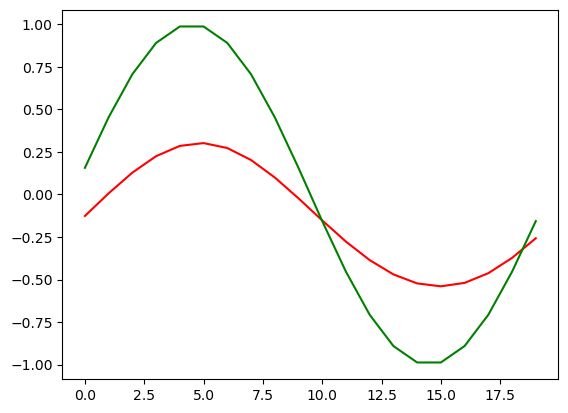

0 1.9360674946026686 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 's5', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', -8.368, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's2', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']


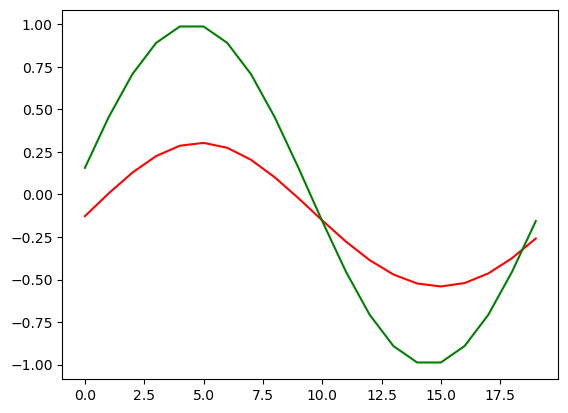

0 1.9322443179162583 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 's5', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']


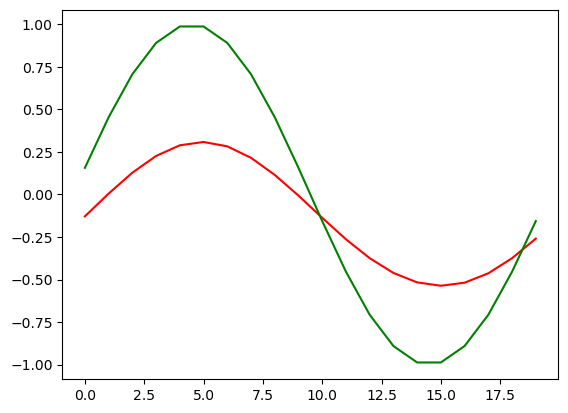

0 1.9302015105482442 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 's5', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']


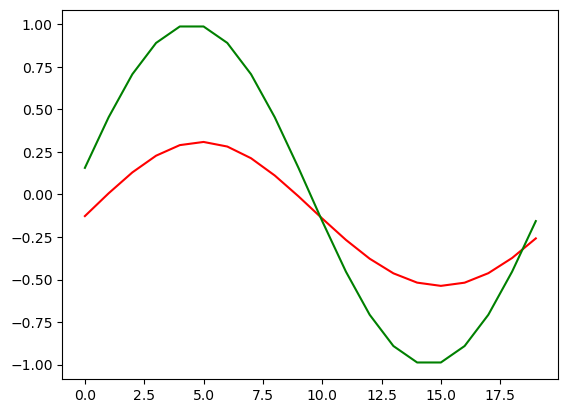

1 1.9302015105482442 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 's5', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
2 1.9302015105482442 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 's5', 'math.sin', 's6', '*', '+', '-', 

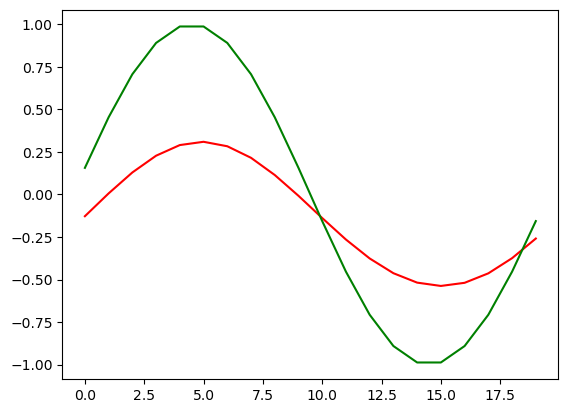

4 1.9284917206913537 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
4 1.9282718252730104 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '

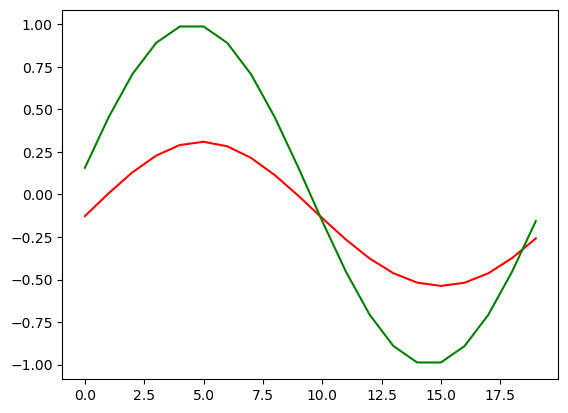

5 1.9282718252730104 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
6 1.9282718252730104 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '

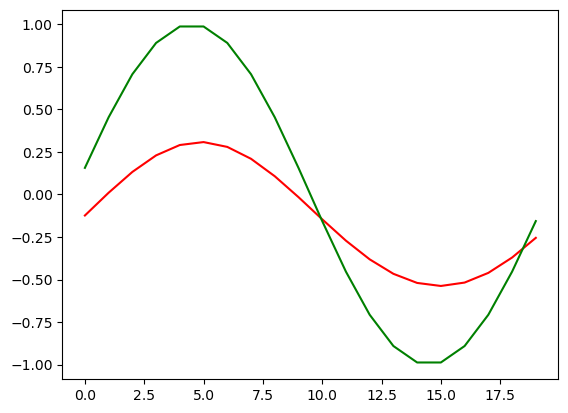

8 1.9282428785815984 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '-', 'math.log', 's19', 'math.cos', 's12', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's4', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
9 1.9282428785815984 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-

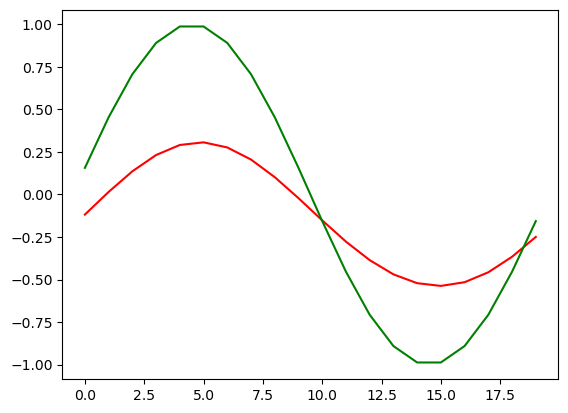

11 1.9268248637110061 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '*', 's21', 's8', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']


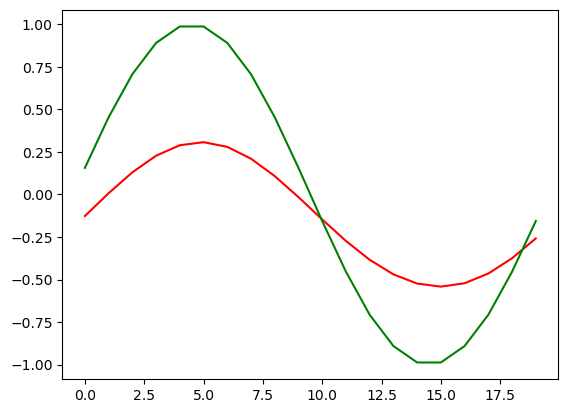

11 1.9264822223603535 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '*', 's21', 's8', 'math.log', 's21', '+', '-', 'math.log', '-', '+', -6.689, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']


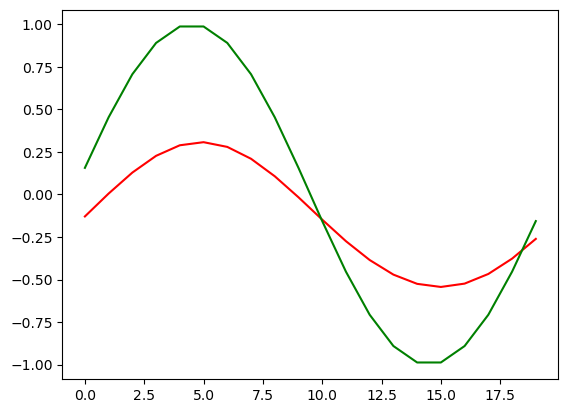

12 1.9264822223603535 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '*', 's21', 's8', 'math.log', 's21', '+', '-', 'math.log', '-', '+', -6.689, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
12 1.925653612317533 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.

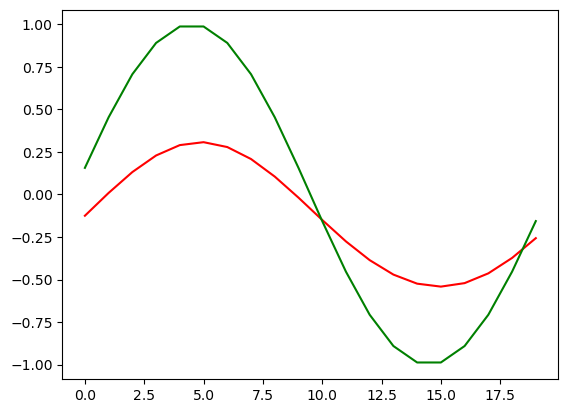

13 1.925653612317533 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '*', 's21', 's8', 'math.log', 's21', '+', '-', 'math.log', '-', '+', 7.314, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
14 1.925653612317533 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.si

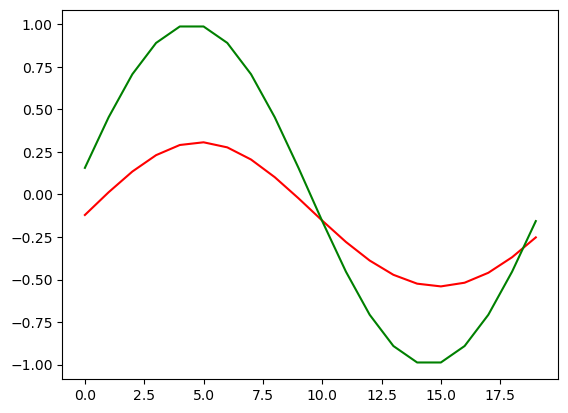

16 1.9250491037791033 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '*', 's21', 's8', 'math.log', 's21', '+', '-', 'math.log', '-', '+', -6.689, 'math.log', 's6', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's14', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
17 1.9250491037791033 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 

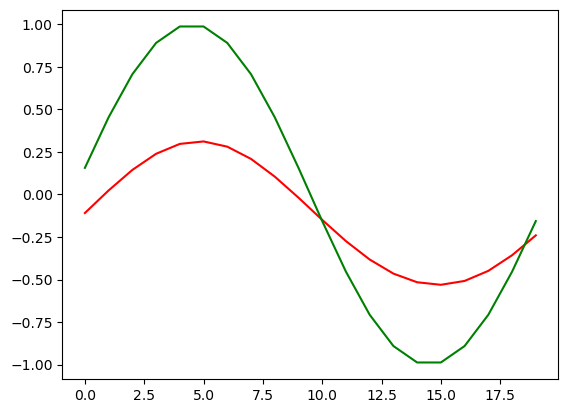

33 1.9189926239583646 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's6', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', '*', 's21', 's8', 'math.log', 's21', '+', '-', 'math.log', '-', '+', -6.689, 's20', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's21', 'math.log', 's4', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's15', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
34 1.9189926239583646 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '

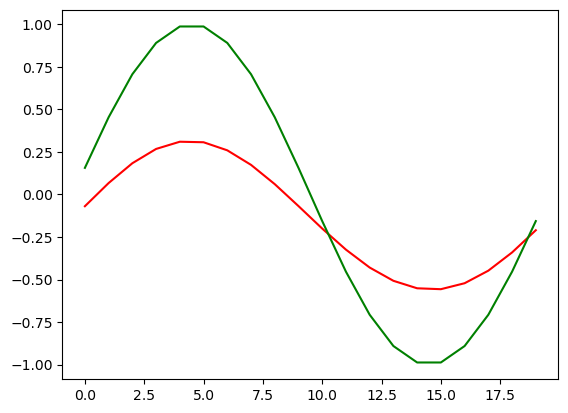

39 1.8737971982478505 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.log', 's21', '+', '-', 'math.log', '-', 'math.tanh', 's17', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 's18', 'math.exp', 's21', 's3', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', '-', 's21', 's4', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']
40 1.8737971982478505 ['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.

KeyboardInterrupt: 

In [38]:
#############################################################
###Linear full row target, two row control.##########################
#############################################################
####Currently not using gymnasium, need to remove some comments and update gym to use with gymansium###
import matplotlib.pyplot as plt
#need to update use of gym to account for changes made to accomdate SAC script

#env = gym.make("Diffusion-v0")
from pde import DiffusionPDE, ScalarField, UnitGrid
#observation, grid, state0 = env.reset(seed=412) uncomment for use with gym
grid = pde.CartesianGrid([[0, 1], [0, 1]], [20, 20], periodic=[False, True]) # generate grid, remove if use gym
state = ScalarField.random_uniform(grid, 0.0, 0.2)  #remove if use gym
#####notes on using gymnasium with py-pde######
#observation needs to be full grid area, but number of sensors will probably be less

#array with target values for sensors

Ni=500 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.4 #for reseed, precent reseeded each round

Num_sens=grid.shape[0] #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then x,y are last 2 elements

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=500 #set max number of iterations
dt=0.01 #timestep for iteration


left_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][0].item())  #
left_bound=np.vstack((left_bound, grid.axes_coords[1]))
right_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][1].item())#
right_bound=np.vstack((right_bound, grid.axes_coords[1]))

# bottom_bound=grid.axes_coords[0]
# bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
# top_bound=grid.axes_coords[0]
# top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

# #initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
right_control=np.zeros(grid.shape[1])
# bottom_control=np.zeros(grid.shape[0])
# top_control=np.zeros(grid.shape[0])
print(left_bound)
print(right_bound)

#set up target and evaluation parameters to evaluate reward
target=1.*np.sin(2*grid.axes_coords[1]*3.14159265)

#implement=controller(grid, state, Num_sens) #for using gym

# forest=[]
# #generate forest of Ni trees
# for i in range(0,Ni):
#     seed=gp.sapling(10,20,Ns)
#     trial=gp.growTrig(0,2,seed)
#     forest.append(seed)

minJ=50000 #set initial "best" cost
m=0 #iteration counter
max_t=0.

state = ScalarField.random_uniform(grid, 0.0, 0.2) 

bc_y_left={"value": 0}
bc_y_right={"value": 0}
bc_x=[bc_y_left, bc_y_right]
bc_y="periodic"
#bc_x="periodic"
eq = DiffusionPDE(diffusivity=.1, bc=[bc_x, bc_y])
solver=pde.ExplicitSolver(eq, scheme="euler", adaptive = True)
#result = eq.solve(state, t_range=dt, adaptive=True, tracker=None)
stepper=solver.make_stepper(state, dt=1e-3)

while (minJ>1. and m<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    #n=random.randint(0,10000)
    nt=0
    for t in forest:
        subtotal=0
        nt+=1
        state = ScalarField.random_uniform(grid, 0.0, 0.2) 
        #reset the environment for each tree using same enivornment for each tree with each time step
        #observation, grid, state = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        #grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
 #remove if use gym
        t.total=0
        #reset to random initial condition.  For now, same random initial condition for all training to avoid favoring "lucky" starts
        #implement.state=state0
        time1=time.time()
        time1a=process_time()
        t_current=0.
        for i in range(150):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            #will need to also replace x and y values for controller locations, which result in a vector of results
            #one element per controller
            #probably have each controller operate across several cells
            #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value
            s=state.data[9,:] #change to implemetn state if gym
            #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
            for j in range(Num_sens):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]  
            #assign values to boundary controls.  
            #this implementation ASSUMES square grid.  
            #if rectangular need to break into iterating over left/right and top/bottom
            for j in range(grid.shape[0]):
                #left bound
                holder_left=copy.copy(control_name)
                holder_right=copy.copy(control_name)
                # holder_top=copy.copy(control_name)
                # holder_bottom=copy.copy(control_name)
                for l in range(Num_sens, Ns):
                    obs_name='s'+str(l)
                    holder_left=[left_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_left]
                    holder_right=[right_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_right]
                    # holder_bottom=[bottom_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_bottom]
                    # holder_top=[top_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_top]
                k,dummy=gp.evaluate(holder_left)
                if k>50:  k=50.0
                elif k<-50:  k=-50.0
                left_control[j]=k

                kr,dummy=gp.evaluate(holder_right)
                if kr>50:  kr=50.0
                elif kr<-50:  kr=-50.0
                right_control[j]=kr
                # k,dummy=gp.evaluate(holder_right)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # right_control[j]=k
                # k,dummy=gp.evaluate(holder_bottom)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # bottom_control[j]=k
                # k,dummy=gp.evaluate(holder_top)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # top_control[j]=k

            #now set up entire array to pass for the boundary
            #hard coded that non-control points will be 0, control points will be as appropriate for that control value
            #need to keep order of boundaries straight for K, for passing to gymnasium, and in gymnasium
            #left, right, bottom, top
            #all_control=np.vstack([left_control, right_control])
            #all_control=np.vstack([all_control, bottom_control])
            #all_control=np.vstack([all_control, top_control])

            
            #bc_x_right={"value": 0}
            #bc_x_left={"value": left_control}
            #bc_x=[bc_x_left, bc_x_right]


            #implement.state.data[:,1]=left_control #uncomment for gym
            state.data[1,:]=left_control #coordinates will be 1*dx off, so not "leaerning" exact physics
            state.data[18,:]=right_control
            start=time.time()
            
            t_current=stepper(state, t_current, t_current+dt)
    
            t_check=time.time()-start
            result=state

            reward=(state.data[9,:]-target)**2
            reward=1*math.sqrt(np.sum(np.sum(reward)))
            if reward<0.5: #if average less than about 0.1 difference from target, consider done
                reward+=-50
                break
            if len(t.name)>125:
                reward+=30
            if np.max(state.data)>50 or np.min(state.data)<-50:
                reward+=100
                print('diverge')
            if t_check>max_t and i>3:
                #print(t_check, m, nt, i)
                max_t=t_check
            #if i>5 and nt>0 and i<10:
                #print(t_check, nt, i)
            #if i>35 and nt>0 and i<40:
                
            subtotal+=reward
            #state=result


        t.total=reward#subtotal #use reward instead of subtotal if only interested in final state
        # if nt>5 and nt<10:
        #     print("loop time:  ",time.time()-time1, t_check, m, nt)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(m, minJ, bestTree)
            plt.plot(state.data[9,:], 'r') # plotting t, a separately 
            #plt.plot(state.data[:,9], 'b') # plotting t, b separately 
            plt.plot(target, 'g') # plotting t, c separately 
            plt.show()
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    
    forest=gp.evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)
    m+=1
    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
    print(m, minJ, bestTree)    

[ 0.04806664  0.06691967  0.08077894  0.08825358  0.08892225  0.08319737
  0.07206513  0.0568375   0.03897932  0.02000886  0.00144318 -0.01524121
 -0.02865458 -0.03756017 -0.04096554 -0.0382387  -0.02924555 -0.01449571
  0.00474415  0.02645275]
[ 0.15643446  0.4539905   0.70710678  0.89100652  0.98768834  0.98768834
  0.89100653  0.70710678  0.4539905   0.15643447 -0.15643446 -0.4539905
 -0.70710678 -0.89100652 -0.98768834 -0.98768834 -0.89100653 -0.70710679
 -0.45399051 -0.15643447]
[-0.10836783 -0.38707083 -0.62632784 -0.80275295 -0.89876609 -0.90449097
 -0.8189414  -0.65026929 -0.41501118 -0.13642561  0.15787765  0.43874929
  0.6784522   0.85344635  0.9467228   0.94944964  0.86176098  0.69261108
  0.45873466  0.18288723]
2.962865575353333


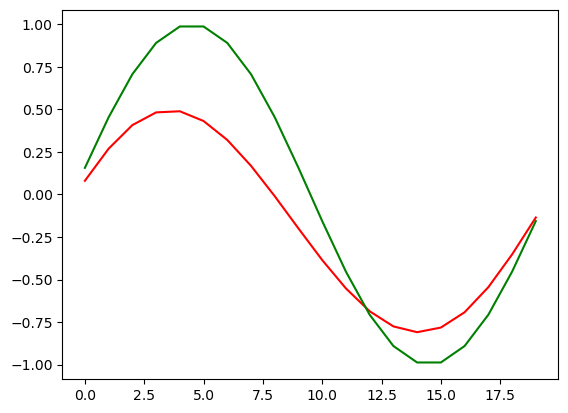

In [40]:
from pde import DiffusionPDE, ScalarField, UnitGrid
import matplotlib.pyplot as plt

grid = pde.CartesianGrid([[0, 1], [0, 1]], [20, 20], periodic=[False, True]) 
state = ScalarField.random_uniform(grid, 0.0, 0.2) 
bc_y_left={"value": 0}
bc_y_right={"value": 0}
bc_x=[bc_y_left, bc_y_right]
bc_y="periodic"
#bc_x="periodic"
eq = DiffusionPDE(diffusivity=.1, bc=[bc_x, bc_y])
solver=pde.ExplicitSolver(eq, scheme="euler", adaptive = True)
#result = eq.solve(state, t_range=dt, adaptive=True, tracker=None)
stepper=solver.make_stepper(state, dt=1e-3)
best=['-', '-', '-', 'math.tanh', '+', '+', 'math.cos', 'math.tanh', '-', 's21', 's4', 'math.sin', 's6', '*', '+', '-', '-', '-', 'math.tanh', 's1', 'math.exp', '+', 'math.tanh', 'math.exp', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.log', 's21', '+', '-', 'math.log', '-', 'math.tanh', 's17', 's21', 'math.sin', '*', 's21', 's8', 'math.exp', 's10', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 's18', 'math.exp', 's21', 's3', '*', 's21', 's21', 's20', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', '-', 's21', 's4', '+', '-', 'math.log', 'math.tanh', '-', 's21', 's4', 'math.sin', 'math.sin', 'math.log', 'math.log', 'math.log', 's6', 'math.exp', 's10']

left_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][0].item())  #
left_bound=np.vstack((left_bound, grid.axes_coords[1]))
right_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][1].item())#
right_bound=np.vstack((right_bound, grid.axes_coords[1]))

# bottom_bound=grid.axes_coords[0]
# bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
# top_bound=grid.axes_coords[0]
# top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

# #initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
right_control=np.zeros(grid.shape[1])
dt=0.1

Num_sens=grid.shape[0]
Ns=2+Num_sens
t_current=0
for i in range(250):
    control_name=best
    #need to replace each "sensor" value with updated observation
    #will need to also replace x and y values for controller locations, which result in a vector of results
    #one element per controller
    #probably have each controller operate across several cells
    #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value
    s=state.data[9,:] #change to implemetn state if gym
    #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
    for j in range(Num_sens):
        obs_name='s'+str(j)
        control_name=[s[j].item() if c==obs_name else c for c in control_name]  
    #assign values to boundary controls.  
    #this implementation ASSUMES square grid.  
    #if rectangular need to break into iterating over left/right and top/bottom
    for j in range(grid.shape[0]):
        #left bound
        holder_left=copy.copy(control_name)
        holder_right=copy.copy(control_name)
        # holder_top=copy.copy(control_name)
        # holder_bottom=copy.copy(control_name)
        for l in range(Num_sens, Ns):
            obs_name='s'+str(l)
            holder_left=[left_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_left]
            holder_right=[right_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_right]
            # holder_bottom=[bottom_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_bottom]
            # holder_top=[top_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_top]
        k,dummy=gp.evaluate(holder_left)
        #k=10.*k
        if k>50:  k=50.0
        elif k<-50:  k=-50.0
        left_control[j]=k

        kr,dummy=gp.evaluate(holder_right)
        if kr>50:  kr=50.0
        elif kr<-50:  kr=-50.0
        right_control[j]=kr

    #bc_x=[bc_x_left, bc_x_right]


    #implement.state.data[:,1]=left_control #uncomment for gym
    state.data[1,:]=left_control #coordinates will be 1*dx off, so not "leaerning" exact physics
    #state.data[18,:]=right_control
    start=time.time()
    
    t_current=stepper(state, t_current, t_current+dt)

    t_check=time.time()-start
    result=state

print(state.data[9,:])
target = 1.*np.sin(2*grid.axes_coords[1]*3.14159265)
print(target)
reward=(state.data[9,:]-target)**2
print(state.data[9,:]-target)
print(math.sqrt(np.sum(np.sum(reward))))

plt.plot(10.*state.data[9,:]-0.4, 'r') # plotting t, a separately 
#plt.plot(state.data[:,9], 'b') # plotting t, b separately 
plt.plot(target, 'g') # plotting t, c separately 
plt.show()

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 5.25 5.75 6.25 6.75
  7.25 7.75 8.25 8.75 9.25 9.75]]
[[10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.
  10.   10.   10.   10.   10.   10.   10.   10.  ]
 [ 0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75
   6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75]]
diverge
0 626.8461992233132 ['-', '*', 'math.cos', 'math.cos', '-', 'math.cos', '*', '+', '*', 'math.cos', 's7', '+', 's5', 's8', '+', '*', 's14', 's2', 'math.cos', 's2', '*', '+', 'math.cos', '-', 's13', 's16', '+', 's2', 's10', '+', '*', 's20', '+', 'math.cos', 's12', 's6', 'math.sin', 's13', 'math.sin', 'math.cos', '-', '+', '+', 's15', 's6', '+', 's7', 's2', '*', '+', '+', 's19', 's4', 's19', '+', '+', '*', 'math.cos', '+', 's12', 's6', -4.921, 's15', 's15', '+', '+', '-', '+', '+', '*', '+', 'math.cos', 5.064, 'math.sin', -8.976, '

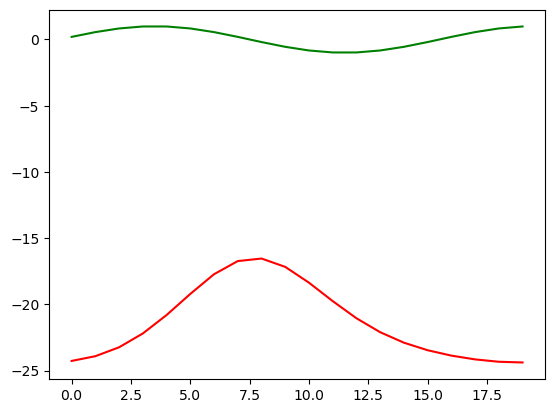

0 53.22249864575254 ['+', 'math.cos', 'math.cos', '*', '-', '-', '-', '+', 'math.cos', '-', 's0', 's16', '-', '+', 's14', 's19', '-', 'math.sin', 's6', 's17', '-', '+', 'math.cos', 's3', '+', 's12', 's21', '+', '+', 's8', 's3', '+', -0.165, 's18', '*', '-', 'math.cos', 'math.cos', 's3', '+', 'math.sin', 's9', 'math.cos', 's13', 'math.sin', 'math.sin', '*', 's21', '*', 's9', 'math.sin', 's12', '*', '-', 'math.sin', 'math.sin', '*', 'math.cos', '*', 's21', 's9', '*', 'math.cos', 's13', 's11', '*', '+', '-', 's17', 's9', '-', '-', 's8', 's14', 's12', 'math.sin', '-', 's7', 's10', '-', '*', 'math.cos', '*', 'math.sin', 's12', 's4', '-', 'math.cos', 's20', 'math.sin', 's3', 'math.cos', '*', '-', 's19', 's15', 'math.cos', 's1', 'math.cos', '*', '+', 'math.cos', '*', '*', 's5', 's9', 'math.cos', 's18', 'math.sin', '*', '-', 's0', 's1', 'math.sin', 's3', '*', 'math.cos', 'math.sin', '-', 's13', 's4', '*', '*', 'math.cos', 's8', 'math.cos', 's9', 'math.sin', '+', 's12', 's13', '*', 'math.sin', 

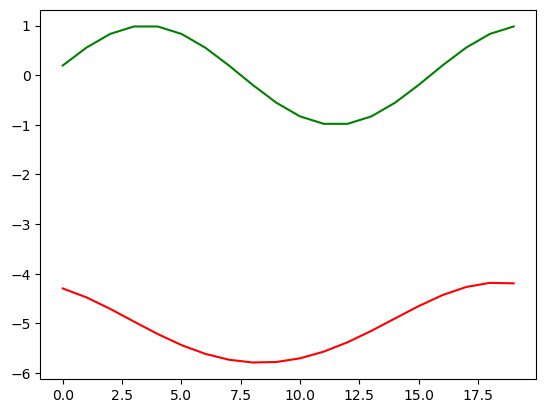

diverge
diverge
0 33.5822615200798 ['*', '*', 'math.sin', '+', 'math.cos', 'math.cos', '-', '+', 'math.sin', '-', 's1', 's14', '*', 'math.cos', 's1', 'math.cos', 's7', '+', 'math.sin', '-', 's19', '*', 's15', 's1', '-', '*', '*', 's4', 9.969, 'math.sin', 'math.cos', 's2', '-', 's5', 's4', 'math.sin', '*', 'math.cos', '*', 'math.sin', '+', 's3', 'math.cos', 's5', 'math.cos', '+', 's19', 's9', '+', 'math.cos', 'math.sin', '-', 's10', 's6', 'math.cos', 'math.cos', 'math.sin', '+', 's11', 's15', '-', 'math.cos', 'math.sin', '+', '-', '+', '-', 'math.cos', 's17', 'math.cos', 's9', '*', '+', 's11', 's0', '+', 's10', 'math.cos', '-', '*', 's8', 's21', 's19', '+', '*', 'math.cos', 's17', '*', 's8', 'math.sin', -9.193, '+', '-', 's16', 's12', 'math.sin', 's16', '-', 'math.sin', 'math.sin', 'math.sin', 's5', 'math.sin', 'math.cos', '*', '*', 's21', 's18', 's1', 'math.sin', '*', '*', 'math.cos', '+', 'math.sin', '*', 's12', 's19', '*', '*', 's7', 'math.sin', 's0', 'math.sin', 's1', 'math.cos', 'm

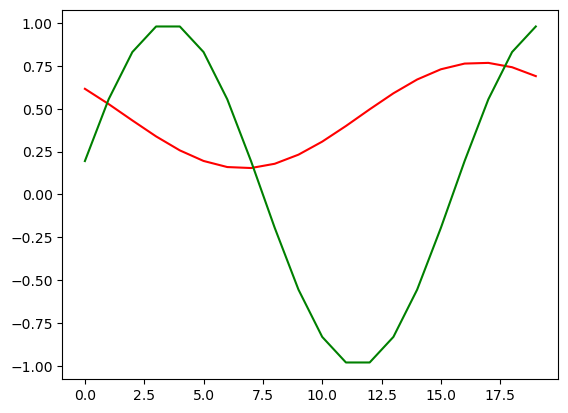

0 26.987409132003563 ['math.cos', 'math.sin', 'math.cos', '+', 'math.cos', '-', '-', 'math.cos', 'math.cos', 'math.cos', 's13', '-', '*', 'math.cos', 3.377, '*', '+', 's11', '*', 's15', 's17', 's16', '+', '+', 's1', 's12', '*', 's6', 's3', 'math.sin', '*', '*', '*', 's2', 's4', '+', 's10', 's11', '-', '-', 's4', 's1', 'math.cos', 's3', 'math.cos', 'math.cos', '-', '-', 'math.cos', '+', 's11', 's9', '-', '+', 's12', 's5', '-', 's4', 's16', 'math.sin', '*', 'math.sin', 's18', 'math.sin', '*', 6.228, 's12']


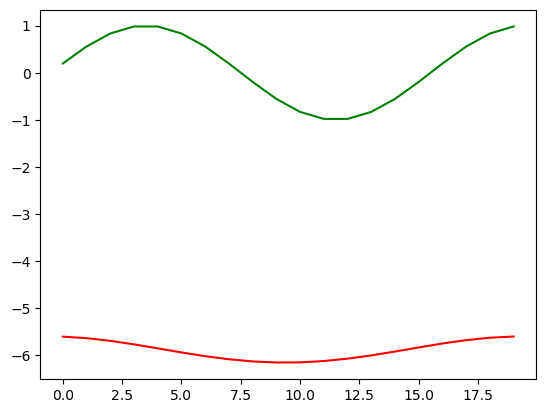

0 23.210647856643075 ['math.cos', 'math.sin', 'math.cos', 'math.sin', '*', '*', '+', 'math.cos', '*', 'math.cos', 's1', '+', 's5', 's10', '+', 'math.cos', '+', 's5', 's10', 'math.cos', '*', -1.19, 's13', 'math.sin', '*', '+', 'math.cos', 's13', 'math.cos', 's10', 'math.cos', 'math.sin', 's11', 'math.cos', '+', '+', 'math.cos', '+', 's19', 's1', '-', '+', 's7', 's10', 'math.cos', 's21', 'math.cos', '+', '-', 's8', 's7', 'math.sin', 's2']


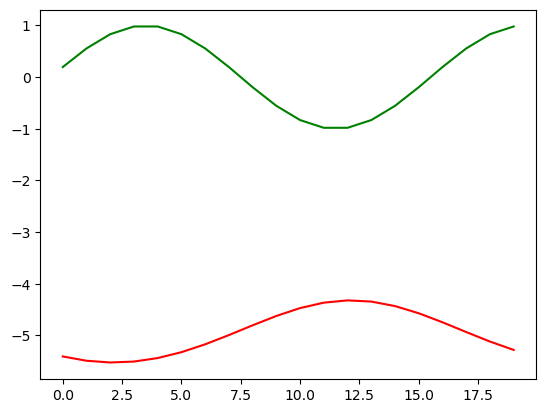

diverge
0 21.01469148241793 ['math.cos', 'math.cos', 'math.cos', 'math.cos', 'math.sin', '*', 'math.cos', 'math.sin', '-', '*', 's19', 's21', '-', '*', 's3', 'math.cos', 's12', 's20', 'math.cos', 'math.sin', 'math.cos', '+', 's13', '*', 's5', 's19']


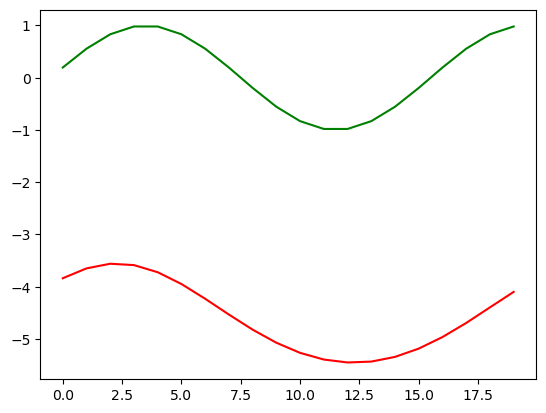

diverge
diverge
0 19.274301401736896 ['math.cos', 'math.cos', '*', '-', 'math.sin', '-', 'math.sin', 'math.cos', '*', 'math.cos', 's17', 'math.cos', 's5', '-', 'math.cos', '*', '-', 's1', 's6', 'math.cos', 's19', '+', 'math.cos', '+', 's18', 's12', 'math.sin', '*', 's2', 's6', 'math.sin', '-', '+', '*', '-', 'math.cos', 's19', '+', '*', 's12', 's19', 's10', '-', 'math.sin', 's7', '+', -0.811, 's13', '*', 'math.sin', '+', 's10', 's10', '+', '-', 's5', 's0', 'math.cos', 's9', '-', 'math.sin', 'math.sin', 'math.cos', 's19', '+', '-', '*', 's13', 's5', '-', 's16', 's3', '*', '-', 's19', 's5', '-', 2.592, 's21', '*', '-', '*', '-', '*', '-', '-', 's21', 's0', 'math.sin', 's1', '-', '*', '+', 's2', 's4', 's17', 'math.sin', 'math.cos', 's8', 'math.sin', 'math.sin', 'math.sin', 's17', '-', '-', 'math.cos', '-', 'math.sin', 's10', '+', 's8', 'math.cos', 's19', 'math.cos', 'math.sin', 'math.sin', 's12', 'math.sin', 'math.cos', 'math.cos', 's3', 'math.cos', 'math.sin', 'math.cos', '-', 'math.cos'

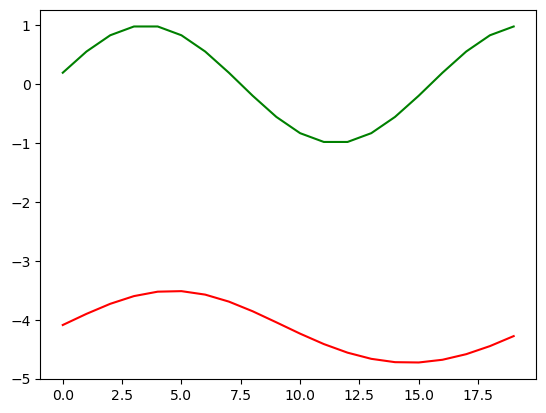

diverge
diverge
diverge
0 2.7246052391857836 ['math.sin', 'math.sin', 'math.sin', '-', 'math.sin', 'math.cos', '*', 'math.cos', 'math.sin', 'math.cos', 's3', '+', 'math.sin', '*', 's3', 's12', '*', 'math.sin', 's18', 'math.sin', 'math.sin', 's7', 'math.sin', 'math.sin', '+', '-', '*', '+', 'math.cos', 's9', 's12', 'math.cos', 's17', '*', 'math.sin', 's6', '*', 's13', 's8', 'math.cos', '*', 'math.sin', 's4', '*', 's5', 's14']


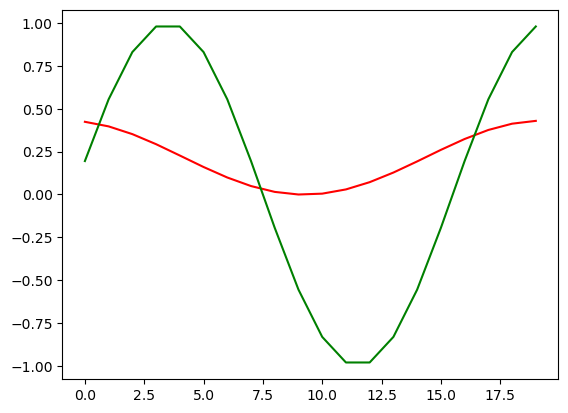

diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
0 2.1554107323976437 ['math.sin', 'math.sin', 'math.sin', '+', '-', 'math.cos', '+', '+', 'math.cos', '-', 's15', 's1', '+', '*', 's20', 's16', '-', 's10', '*', 's17', 's4', '*', '+', '-', 's12', 's7', 'math.cos', 's10', '+', '+', '-', 's19', 's2', 's2', 'math.sin', 's6', 'math.cos', '*', '-', 'math.sin', 'math.cos', 's3', '-', '+', 'math.cos', 's8', 's2', '+', 's3', 's17', 'math.sin', '+', 'math.cos', 's12', 'math.cos', 's5', 'math.sin', '*', '+', 'math.sin', '+', '+', 'math.cos', 's21', 's18', '*', 'math.cos', 's1', 's1', '+', '*', 'math.cos', '+', '*', 's15', 's13', 's5', '*', 's18', 's4', 'math.si

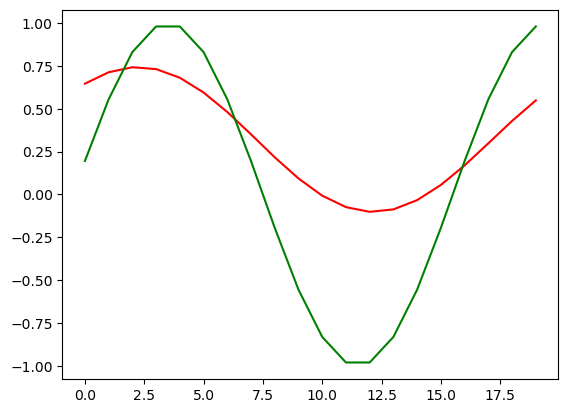

diverge
diverge
diverge
1 2.1554107323976437 ['math.sin', 'math.sin', 'math.sin', '+', '-', 'math.cos', '+', '+', 'math.cos', '-', 's15', 's1', '+', '*', 's20', 's16', '-', 's10', '*', 's17', 's4', '*', '+', '-', 's12', 's7', 'math.cos', 's10', '+', '+', '-', 's19', 's2', 's2', 'math.sin', 's6', 'math.cos', '*', '-', 'math.sin', 'math.cos', 's3', '-', '+', 'math.cos', 's8', 's2', '+', 's3', 's17', 'math.sin', '+', 'math.cos', 's12', 'math.cos', 's5', 'math.sin', '*', '+', 'math.sin', '+', '+', 'math.cos', 's21', 's18', '*', 'math.cos', 's1', 's1', '+', '*', 'math.cos', '+', '*', 's15', 's13', 's5', '*', 's18', 's4', 'math.sin', '-', 's20', 's20', '+', '*', '-', '+', 's12', 's21', 'math.sin', 's16', '-', 'math.cos', 's9', 'math.sin', 's0', '*', '+', 'math.cos', 's16', 'math.sin', 's19', '+', '+', 's6', 's20', '+', 's7', 's15']
1 2.0541469949256537 ['math.sin', 'math.sin', 'math.sin', '+', '-', 'math.cos', '+', '+', 'math.cos', '-', 's15', 's1', '+', '*', 's20', 's16', '-', 's10', '*', '

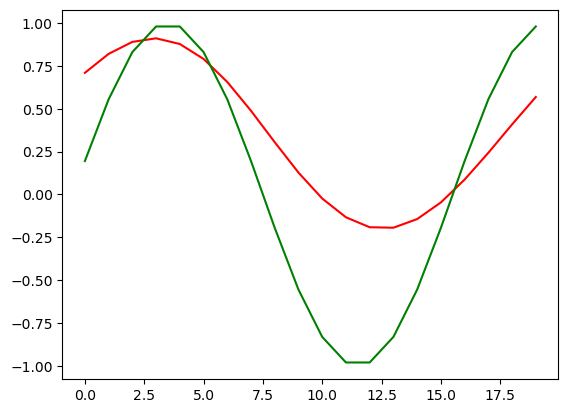

diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
1 1.5049443259127364 ['+', 'math.sin', '+', 'math.cos', 'math.log', 'math.tanh', '-', 'math.exp', 'math.exp', '*', 's4', 's8', 'math.sin', 'math.exp', 'math.exp', 's17', 'math.sin', 'math.log', 'math.sin', '+', '+', '-', 'math.cos', 's0', 'math.tanh', 's18', '*', 'math.log', 's7', '+', 's14', 'math.sin', '-', 's2', 's2', '*', 'math.tanh', 'math.tanh', '-', 's6', 'math.cos', '+', 8.544, '-', 's4', 's6', 'math.tanh', 'math.sin', 's8', '+', 'math.log', 'math.cos', 'math.cos', '-', 'math.exp', 'math.log', 'math.sin', '*', 'math.log', 's9', 's3', 'math.exp', '*', 'math.exp', 'math.exp', 'math.log', 'math.tanh', 'math.log', 's11', '*', 'math.cos', '-', 'math.log', 's20', 'math.exp', 's20', 'math.tanh', 's4', 'math.log', '*', 'math.tanh', 'math.tanh', '-', 'math.sin', '+', '+', 's5', 's14', 'math.log', 's3', '-', '*', 'math.log', 'math.sin', 's19', 'math.sin', 's7', 'math.sin', '+',

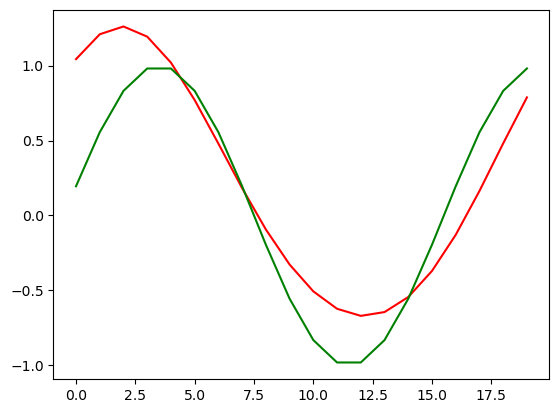

diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
2 1.5049443259127364 ['+', 'math.sin', '+', 'math.cos', 'math.log', 'math.tanh', '-', 'math.exp', 'math.exp', '*', 's4', 's8', 'math.sin', 'math.exp', 'math.exp', 's17', 'math.sin', 'math.log', 'math.sin', '+', '+', '-', 'math.cos', 's0', 'math.tanh', 's18', '*', 'math.log', 's7', '+', 's14', 'math.sin', '-', 's2', 's2', '*', 'math.tanh', 'math.tanh', '-', 's6', 'math.cos', '+', 8.544, '-', 's4', 's6', 'math.tanh', 'math.sin', 's8', '+', 'math.log', 'math.cos', 'math.cos', '-', 'math.exp', 'math.log', 'math.sin', '*', 'math.log', 's9', 's3', 'math.exp', '*', 'math.exp', 'math.exp', 'math.log', 'math.tanh', 'math.log', 's11', '*', 'math.cos', '-', 'math.log', 's20', 'math.exp', 's20', 'math.tanh', 's4', 'math.log', '*', 'math.tanh', 'math.tanh', '-', 'math.sin', '+', '+', 's5', 's14', 'math.log', 's3', '-', '*', 'math.log', 'math.sin', 's19', 'math.sin', 's7', 'math.sin', '+', '*', 's14', 's1', 's7', '-', 'math.exp', 'math.

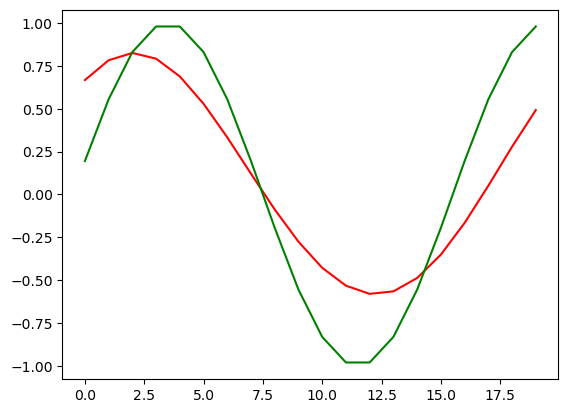

diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
3 1.4776735548863384 ['math.sin', 'math.sin', 'math.sin', '+', '-', 'math.cos', '+', '+', 'math.cos', '-', 's15', 's1', '+', '*', 's20', 's16', '-', 's10', '*', 's17', 's4', '*', '+', '-', 's12', 's7', 'math.cos', 's10', '+', '+', '-', 's19', 's2', 's2', 'math.sin', 's6', 'math.cos', '*', '-', 'math.sin', 'math.cos', 's3', 's11', 'math.sin', '+', 'math.cos', 's12', 'math.cos', 's5', 'math.sin', '*', '+', 'math.sin', '+', '+', 'math.cos', 's21', 's18', '*', 'math.cos', 's1', 's1', '+', '*', 'math.cos', '+', '*', 's15', 's13', 's5', '*', 's18', 's4', 'math.sin', '-', 's20', 's20', '+', '*', '-', '+', 's12', 's21', 'math.sin', 's16', '-', 'math.cos', 's9', 'math.sin', 's0', '*', '+', 'math.cos', 's16', 'math.sin', 's19', '+', '+', 's6', 's20', '+', 's7', 's15']
3 1.4550466292108775 ['+', 'math.sin', '+', 'math.cos', 'math.log', 'math.tanh', '-', 'math.exp

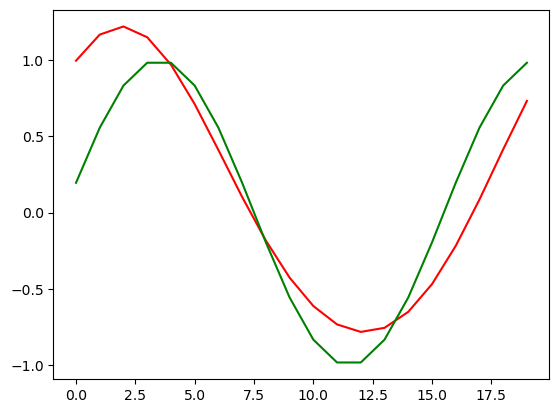

diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
4 1.4550466292108775 ['+', 'math.sin', '+', 'math.cos', 'math.log', 'math.tanh', '-', 'math.exp', 'math.exp', '*', 's4', 's8', 'math.sin', 'math.exp', 'math.exp', 's17', 'math.sin', 'math.log', 'math.sin', '+', '+', '-', 'math.cos', 's0', 'math.tanh', 's18', '*', 'math.log', 's7', '+', 's14', 'math.sin', '-', 's2', 's2', '*', 'math.tanh', 'math.tanh', '-', 's6', 'math.cos', '+', 8.544, '-', 's4', 's6', 'math.tanh', 'math.sin', 's8', '+', 'math.log', 'math.cos', 'math.cos', '-', 'math.exp', 'math.log', 'math.sin', '*', 'math.log', 's9', 's3', 'math.exp', '*', 'math.exp', 'math.exp', 'math.log', 'math.tanh', 'math.log', 's11', '*', 'math.cos', '-', 'math.log', 's20', 'math.exp', 's20', 'math.tanh', 's4', 'math.lo

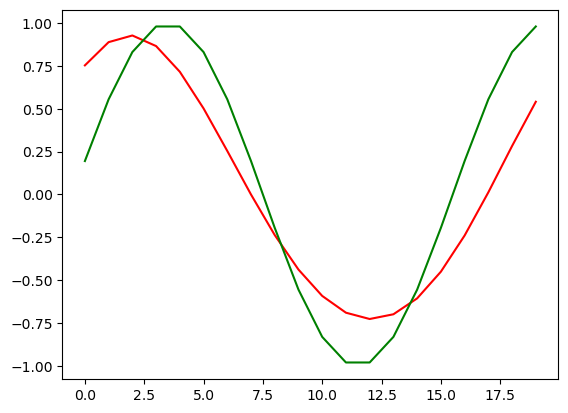

diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
6 1.4276527311637037 ['math.tanh', 'math.sin', '*', '*', 'math.log', 'math.log', '-', 'math.cos', 'math.sin', 'math.cos', 's18', 'math.cos', '+', 'math.sin', 's9', '-', 's20', 's21', '+', 'math.cos', '+', 'math.tanh', 'math.sin', 'math.sin', 's19', 'math.sin', '-', '*', 's21', 's10', 'math.exp', 'math.cos', '*', 's2', 's5', '*', 'math.log', 's17', '+', 'math.sin', '-', '-', 's0', 's9', 'math.tanh', '-', 's12', '+', 'math.exp', 'math.sin', 'math.sin', 's11', 's5', 'math.exp', 'math.log', 'math.cos', 'math.log', 's1', '-', '*', 'math.tanh', 'math.exp', 'math.cos', 'math.log', '-', 's2', 's1', 'math.tanh', 'math.sin', 'math.log', '+', 'math.sin', 's9', '+', 'math.exp', 's14', 's2', 'math.tanh', 'math.sin', 'math.log', '-', 'math.tanh', 'math.sin', 's12', 'math.sin', 'math.sin', '-', 's1', 's13']
diverge
diverge
diverge
diverge
diverge
diverge
diverge
dive

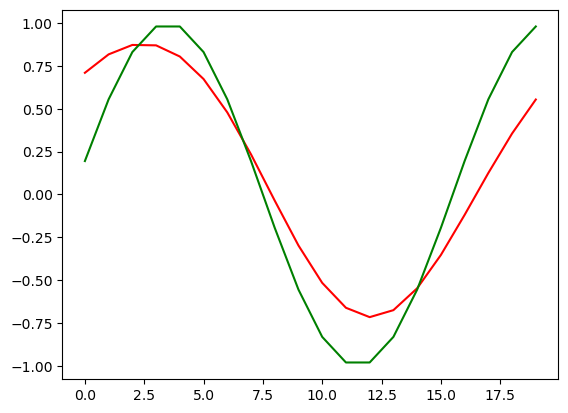

diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
8 1.231084107246069 ['+', 'math.tanh', 's20', 'math.log', '+', 'math.sin', 'math.sin', '*', '*', '-', 's4', 's15', '+', 's6', 's1', 'math.cos', '*', 'math.exp', '+', '-', 's10', 'math.log', 's10', 'math.sin', 's3', 'math.exp', '-', 'math.exp', 's7', 's6', 'math.log', 'math.exp', 'math.sin', 'math.cos', '*', '+', '+', -0.583, -1.738, '+', 's21', 's1', '+', 'math.tanh', 's18', '-', 's21', 's6']
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
diverge
9 1.231084107246069 ['+', 'math.tanh', 's20', 'math.log', '+', 'math.sin', 'math.sin', '*', '*', '-', 's4', 's15', '+', 's6', 's1', 'math.cos', '*', 'math.exp', '+', '-', 's10', 'math.log', 's10', 'math.sin', 's3', 'math.exp', '-', 'math.exp', 's7', 's6', 'math.log', 'math.exp', 'math.sin', 'math.cos', '*', '+', '+', -0.58

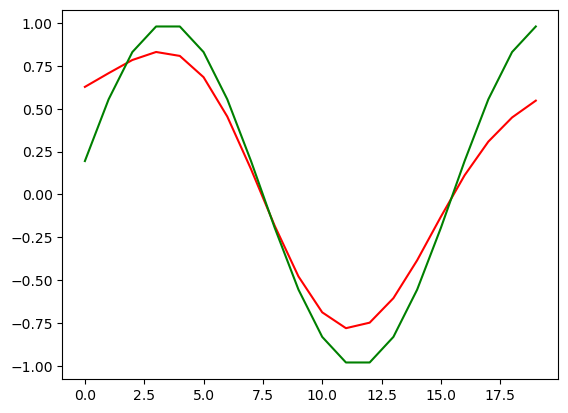

diverge
diverge
18 -49.04862568273364 ['*', 'math.tanh', 'math.sin', '+', '-', 'math.cos', 'math.exp', '-', 'math.exp', 'math.tanh', '-', 'math.sin', 's7', 'math.log', 's16', '*', '-', 's19', 's5', '*', 's15', 's11', '+', 'math.sin', 'math.sin', 'math.cos', '+', 's21', 's5', '*', 'math.log', '+', '*', 's11', 'math.cos', 's16', 'math.sin', 's19', '*', 'math.log', 'math.cos', 's2', 'math.cos', '-', 's9', 'math.cos', 's10', 'math.exp', '*', '-', '+', '*', '-', 's9', 's7', 'math.sin', 's8', 'math.log', 'math.cos', 's16', '-', '+', 'math.log', 's0', '+', 's2', 9.273, '-', 'math.tanh', 's19', '*', 's1', 's6', '-', 'math.exp', 'math.cos', 'math.exp', 'math.sin', 's13', '-', '*', 'math.cos', 's15', '-', 's12', 's14', '*', 'math.tanh', '-', 's17', 's9', 'math.cos', 's12', 'math.exp', 'math.exp', '+', '-', '+', 'math.tanh', 'math.cos', '*', 'math.log', '+', 's7', '+', 's5', 's2', '-', 's11', 'math.log', 's4', 'math.log', 'math.cos', '*', 'math.cos', 'math.exp', 's21', 'math.log', 's2', 'math.sin

In [5]:
#############################################################
###KS equation##########################
#############################################################
####Currently not using gymnasium, need to remove some comments and update gym to use with gymansium###
import matplotlib.pyplot as plt
#need to update use of gym to account for changes made to accomdate SAC script

#env = gym.make("Diffusion-v0")
from pde import PDE, ScalarField, UnitGrid
#observation, grid, state0 = env.reset(seed=412) uncomment for use with gym
grid = pde.CartesianGrid([[0, 10], [0, 10]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
state = ScalarField.random_uniform(grid, 0.0, 0.5)  #remove if use gym
#####notes on using gymnasium with py-pde######
#observation needs to be full grid area, but number of sensors will probably be less

#array with target values for sensors

Ni=500 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.4 #for reseed, precent reseeded each round

Num_sens=grid.shape[0] #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=grid_dim+Num_sens #sensors are first in s array, then x,y are last 2 elements

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=500 #set max number of iterations
dt=0.1 #timestep for iteration


left_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][0].item())  #
left_bound=np.vstack((left_bound, grid.axes_coords[1]))
right_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][1].item())#
right_bound=np.vstack((right_bound, grid.axes_coords[1]))

# bottom_bound=grid.axes_coords[0]
# bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
# top_bound=grid.axes_coords[0]
# top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

# #initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
right_control=np.zeros(grid.shape[1])
# bottom_control=np.zeros(grid.shape[0])
# top_control=np.zeros(grid.shape[0])
print(left_bound)
print(right_bound)

#set up target and evaluation parameters to evaluate reward
target=1.*np.sin(0.25*grid.axes_coords[1]*3.14159265)

#implement=controller(grid, state, Num_sens) #for using gym

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=gp.sapling(10,20,Ns)
    trial=gp.growTrig(0,2,seed)
    forest.append(seed)

minJ=50000 #set initial "best" cost
m=0 #iteration counter
max_t=0.

state = ScalarField.random_uniform(grid, 0.0, 0.5) 

bc_y_left={"value": 0}
bc_y_right={"value": 0}
bc_x=[bc_y_left, bc_y_right]
bc_y="periodic"
#bc_x="periodic"
eq = PDE({"u": "-gradient_squared(u) / 2 - laplace(u + laplace(u))"}, bc=[bc_y, bc_y])
solver=pde.ExplicitSolver(eq, scheme="euler", adaptive = True)
#result = eq.solve(state, t_range=dt, adaptive=True, tracker=None)
stepper=solver.make_stepper(state, dt=1e-3)

while (minJ>1. and m<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    #n=random.randint(0,10000)
    nt=0
    for t in forest:
        subtotal=0
        nt+=1
        state = ScalarField.random_uniform(grid, 0.0, 0.2) 
        #reset the environment for each tree using same enivornment for each tree with each time step
        #observation, grid, state = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        #grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[True, True]) # generate grid, remove if use gym
 #remove if use gym
        t.total=0
        #reset to random initial condition.  For now, same random initial condition for all training to avoid favoring "lucky" starts
        #implement.state=state0
        time1=time.time()
        time1a=process_time()
        t_current=0.
        for i in range(150):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            #will need to also replace x and y values for controller locations, which result in a vector of results
            #one element per controller
            #probably have each controller operate across several cells
            #best to just make an array of control inputs here or in gym and then push to py-pde boundary as value
            s=state.data[9,:] #change to implemetn state if gym
            #to make control/boundary array, first update algorthim variables with sensor values (1:n-2 variables)
            for j in range(Num_sens):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]  
            #assign values to boundary controls.  
            #this implementation ASSUMES square grid.  
            #if rectangular need to break into iterating over left/right and top/bottom
            for j in range(grid.shape[0]):
                #left bound
                holder_left=copy.copy(control_name)
                holder_right=copy.copy(control_name)
                # holder_top=copy.copy(control_name)
                # holder_bottom=copy.copy(control_name)
                for l in range(Num_sens, Ns):
                    obs_name='s'+str(l)
                    holder_left=[left_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_left]
                    holder_right=[right_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_right]
                    # holder_bottom=[bottom_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_bottom]
                    # holder_top=[top_bound[l-Num_sens,j].item() if c==obs_name else c for c in holder_top]
                k,dummy=gp.evaluate(holder_left)
                if k>10:  k=10.0
                elif k<-10:  k=-10.0
                left_control[j]=k

                # kr,dummy=gp.evaluate(holder_right)
                # if kr>50:  kr=50.0
                # elif kr<-50:  kr=-50.0
                # right_control[j]=kr
                # k,dummy=gp.evaluate(holder_right)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # right_control[j]=k
                # k,dummy=gp.evaluate(holder_bottom)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # bottom_control[j]=k
                # k,dummy=gp.evaluate(holder_top)
                # if k>5:  k=5.0
                # elif k<-5:  k=-5.0
                # top_control[j]=k

            #now set up entire array to pass for the boundary
            #hard coded that non-control points will be 0, control points will be as appropriate for that control value
            #need to keep order of boundaries straight for K, for passing to gymnasium, and in gymnasium
            #left, right, bottom, top
            #all_control=np.vstack([left_control, right_control])
            #all_control=np.vstack([all_control, bottom_control])
            #all_control=np.vstack([all_control, top_control])

            
            #bc_x_right={"value": 0}
            #bc_x_left={"value": left_control}
            #bc_x=[bc_x_left, bc_x_right]


            #implement.state.data[:,1]=left_control #uncomment for gym
            state.data[1,:]=left_control #coordinates will be 1*dx off, so not "leaerning" exact physics
            # state.data[18,:]=right_control
            start=time.time()
            
            t_current=stepper(state, t_current, t_current+dt)
    
            t_check=time.time()-start
            result=state

            reward=(state.data[9,:]-target)**2
            reward=1*math.sqrt(np.sum(np.sum(reward)))
            if reward<1.0: #if average less than about 0.1 difference from target, consider done
                reward+=-50
                break
            if len(t.name)>150:
                reward+=30
            if np.max(state.data)>30 or np.min(state.data)<-30:
                reward+=500
                print('diverge')
                break
            if t_check>max_t and i>3:
                #print(t_check, m, nt, i)
                max_t=t_check
            #if i>5 and nt>0 and i<10:
                #print(t_check, nt, i)
            #if i>35 and nt>0 and i<40:
                
            subtotal+=reward
            #state=result


        t.total=reward#subtotal #use reward instead of subtotal if only interested in final state
        # if nt>5 and nt<10:
        #     print("loop time:  ",time.time()-time1, t_check, m, nt)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(m, minJ, bestTree)
            plt.plot(state.data[9,:], 'r') # plotting t, a separately 
            #plt.plot(state.data[:,9], 'b') # plotting t, b separately 
            plt.plot(target, 'g') # plotting t, c separately 
            plt.show()
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    
    forest=gp.evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)
    m+=1
    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
    print(m, minJ, bestTree)    